In [29]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gurobipy as gp
from gurobipy import GRB

In [24]:

price_data = pd.read_csv("../PriceData.csv")
occ_room1 = pd.read_csv("../OccupancyRoom1.csv")
occ_room2 = pd.read_csv("../OccupancyRoom2.csv")


print("Price Data shape:", price_data.shape)
print("Room 1 Occupancy shape:", occ_room1.shape)
print("Room 2 Occupancy shape:", occ_room2.shape)


Price Data shape: (100, 10)
Room 1 Occupancy shape: (100, 10)
Room 2 Occupancy shape: (100, 10)


In [28]:

price = price_data.to_numpy()
occ1  = occ_room1.to_numpy()
occ2  = occ_room2.to_numpy()

num_days, H = price.shape
assert occ1.shape == (num_days, H)
assert occ2.shape == (num_days, H)

print("Days:", num_days, "Hours:", H)


Days: 100 Hours: 10


In [30]:


# Make sure we can import SystemCharacteristics.py if it's one folder up
sys.path.append("..")

import SystemCharacteristics as SC  # from ../SystemCharacteristics.py
fixed = SC.get_fixed_data()

# Check horizon matches
assert fixed["num_timeslots"] == H, "Mismatch: data hours vs SystemCharacteristics num_timeslots"

params = {}

# Power limits (same max power for both rooms in the provided file)
Pmax = float(fixed["heating_max_power"])
params["P_heater"] = {1: Pmax, 2: Pmax}

# Ventilation power (kW)
params["P_vent"] = float(fixed["ventilation_power"])

# Temperature coefficients
params["z_exch"] = float(fixed["heat_exchange_coeff"])
params["z_loss"] = float(fixed["thermal_loss_coeff"])
params["z_conv"] = float(fixed["heating_efficiency_coeff"])
params["z_cool"] = float(fixed["heat_vent_coeff"])          # cooling when ventilation ON
params["z_occ"]  = float(fixed["heat_occupancy_coeff"])

# Humidity coefficients
params["eta_occ"]  = float(fixed["humidity_occupancy_coeff"])
params["eta_vent"] = float(fixed["humidity_vent_coeff"])    # humidity removed when vent ON

# Thresholds
params["T_low"]  = float(fixed["temp_min_comfort_threshold"])
params["T_ok"]   = float(fixed["temp_OK_threshold"])
params["T_high"] = float(fixed["temp_max_comfort_threshold"])
params["H_high"] = float(fixed["humidity_threshold"])

# Outdoor temperature time series
params["T_out"] = np.array(fixed["outdoor_temperature"], dtype=float)

# Initial conditions (same for both rooms in the fixed file)
T0 = float(fixed["initial_temperature"])
params["T_init"] = {1: T0, 2: T0}
params["H_init"] = float(fixed["initial_humidity"])

# Ventilation minimum up-time (in hours)
params["vent_min_up_time"] = int(fixed["vent_min_up_time"])

print("Loaded params OK. Tout length =", len(params["T_out"]))


Loaded params OK. Tout length = 10


In [31]:
import gurobipy as gp
from gurobipy import GRB

def solve_day_milp(prices, occ1_day, occ2_day, params, output_flag=0):
    H = len(prices)
    R = [1, 2]
    T = range(H)

    m = gp.Model("Restaurant_OIH")
    m.Params.OutputFlag = output_flag

    # Variables
    p = m.addVars(R, T, lb=0.0, name="p")                 # heater power
    v = m.addVars(T, vtype=GRB.BINARY, name="v")          # ventilation

    Temp = m.addVars(R, T, lb=-GRB.INFINITY, name="Temp") # temperature
    Hum  = m.addVars(T, lb=-GRB.INFINITY, name="Hum")     # humidity

    # Helper binaries
    start   = m.addVars(T, vtype=GRB.BINARY, name="start")     # ventilation start
    hum_hi  = m.addVars(T, vtype=GRB.BINARY, name="hum_hi")    # humidity above threshold
    temp_hi = m.addVars(R, T, vtype=GRB.BINARY, name="temp_hi")# temp above T_high

    # Low-temp override with hysteresis
    low_active = m.addVars(R, T, vtype=GRB.BINARY, name="low_active")
    low_trig   = m.addVars(R, T, vtype=GRB.BINARY, name="low_trig")
    below_ok   = m.addVars(R, T, vtype=GRB.BINARY, name="below_ok")

    # Params
    P_heater = params["P_heater"]
    P_vent   = params["P_vent"]

    z_exch = params["z_exch"]
    z_loss = params["z_loss"]
    z_conv = params["z_conv"]
    z_cool = params["z_cool"]
    z_occ  = params["z_occ"]

    eta_occ  = params["eta_occ"]
    eta_vent = params["eta_vent"]

    Tlow  = params["T_low"]
    Tok   = params["T_ok"]
    Thigh = params["T_high"]
    Hhigh = params["H_high"]

    Tout  = np.array(params["T_out"])
    Tinit = params["T_init"]
    Hinit = params["H_init"]

    U = int(params.get("vent_min_up_time", 3))

    # Big-M (safe; can be tightened later)
    M_T = 100.0
    M_H = 200.0

    # Bounds on heater power
    for r in R:
        for t in T:
            m.addConstr(p[r,t] <= P_heater[r], name=f"pmax_{r}_{t}")

    # Initial conditions
    for r in R:
        m.addConstr(Temp[r,0] == Tinit[r], name=f"Tinit_{r}")
    m.addConstr(Hum[0] == Hinit, name="Hinit")

    # Dynamics
    for t in range(1, H):
        for r in R:
            other = 2 if r == 1 else 1
            occ_rt_1 = occ1_day[t-1] if r == 1 else occ2_day[t-1]

            m.addConstr(
                Temp[r,t] ==
                Temp[r,t-1]
                + z_exch*(Temp[other,t-1] - Temp[r,t-1])
                + z_loss*(Tout[t] - Temp[r,t-1])
                + z_conv*p[r,t-1]
                - z_cool*v[t-1]
                + z_occ*occ_rt_1,
                name=f"Tdyn_{r}_{t}"
            )

        m.addConstr(
            Hum[t] ==
            Hum[t-1]
            + eta_occ*(occ1_day[t-1] + occ2_day[t-1])
            - eta_vent*v[t-1],
            name=f"Hdyn_{t}"
        )

    # Ventilation start indicator (assume v[-1]=0)
    for t in T:
        if t == 0:
            m.addConstr(start[t] >= v[t], name="start0")
        else:
            m.addConstr(start[t] >= v[t] - v[t-1], name=f"start_{t}")

    # Ventilation inertia (min up-time U)
    for t in T:
        for k in range(U):
            if t+k < H:
                m.addConstr(v[t+k] >= start[t], name=f"minup_{t}_{k}")

    # Humidity override: if humidity exceeds threshold -> ventilation ON
    for t in T:
        m.addConstr(Hum[t] >= Hhigh - M_H*(1 - hum_hi[t]), name=f"humhi_lb_{t}")
        m.addConstr(Hum[t] <= Hhigh + M_H*(hum_hi[t]), name=f"humhi_ub_{t}")
        m.addConstr(v[t] >= hum_hi[t], name=f"hum_force_{t}")

    # High temperature shutoff: if Temp > Thigh then p=0
    for r in R:
        for t in T:
            m.addConstr(Temp[r,t] >= Thigh - M_T*(1 - temp_hi[r,t]), name=f"thi_lb_{r}_{t}")
            m.addConstr(Temp[r,t] <= Thigh + M_T*(temp_hi[r,t]), name=f"thi_ub_{r}_{t}")
            m.addConstr(p[r,t] <= P_heater[r]*(1 - temp_hi[r,t]), name=f"p_off_hi_{r}_{t}")

    # Low temperature override with hysteresis: if triggered, stay at max until Temp >= Tok
    for r in R:
        for t in T:
            # low_trig indicates Temp below Tlow
            m.addConstr(Temp[r,t] <= Tlow + M_T*(1 - low_trig[r,t]), name=f"lowtrig_ub_{r}_{t}")
            m.addConstr(Temp[r,t] >= Tlow - M_T*(low_trig[r,t]), name=f"lowtrig_lb_{r}_{t}")

            # below_ok indicates Temp below Tok
            m.addConstr(Temp[r,t] <= Tok + M_T*(1 - below_ok[r,t]), name=f"belowok_ub_{r}_{t}")
            m.addConstr(Temp[r,t] >= Tok - M_T*(below_ok[r,t]), name=f"belowok_lb_{r}_{t}")

            if t == 0:
                m.addConstr(low_active[r,t] >= low_trig[r,t], name=f"lowact0_{r}")
            else:
                cont = m.addVar(vtype=GRB.BINARY, name=f"cont_{r}_{t}")
                m.addConstr(cont <= low_active[r,t-1], name=f"cont1_{r}_{t}")
                m.addConstr(cont <= below_ok[r,t],     name=f"cont2_{r}_{t}")
                m.addConstr(cont >= low_active[r,t-1] + below_ok[r,t] - 1, name=f"cont3_{r}_{t}")

                m.addConstr(low_active[r,t] >= low_trig[r,t], name=f"lowact_trig_{r}_{t}")
                m.addConstr(low_active[r,t] >= cont,          name=f"lowact_cont_{r}_{t}")
                m.addConstr(low_active[r,t] <= low_trig[r,t] + cont, name=f"lowact_ub_{r}_{t}")

            # If low_active=1, force heater to max (since p <= Pmax already)
            m.addConstr(p[r,t] >= P_heater[r]*low_active[r,t], name=f"p_on_low_{r}_{t}")

    # Objective: electricity cost
    m.setObjective(
        gp.quicksum(prices[t] * (p[1,t] + p[2,t] + P_vent*v[t]) for t in T),
        GRB.MINIMIZE
    )

    m.optimize()
    if m.Status != GRB.OPTIMAL:
        raise RuntimeError(f"Model not optimal. Status={m.Status}")

    return {
        "obj": m.ObjVal,
        "p1": np.array([p[1,t].X for t in T]),
        "p2": np.array([p[2,t].X for t in T]),
        "v":  np.array([v[t].X  for t in T]),
        "T1": np.array([Temp[1,t].X for t in T]),
        "T2": np.array([Temp[2,t].X for t in T]),
        "H":  np.array([Hum[t].X for t in T]),
    }


In [32]:
daily_costs = []
solutions = {}

example_days = [0, 1]  # pick any two days for plotting later

for d in range(num_days):
    sol = solve_day_milp(
        prices=price[d, :],
        occ1_day=occ1[d, :],
        occ2_day=occ2[d, :],
        params=params,
        output_flag=0
    )
    daily_costs.append(sol["obj"])

    if d in example_days:
        solutions[d] = sol

avg_cost = float(np.mean(daily_costs))
print("Average daily electricity cost over", num_days, "days:", avg_cost)


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2724492
Academic license 2724492 - for non-commercial use only - registered to s2___@dtu.dk
Average daily electricity cost over 100 days: 110.47706237812257


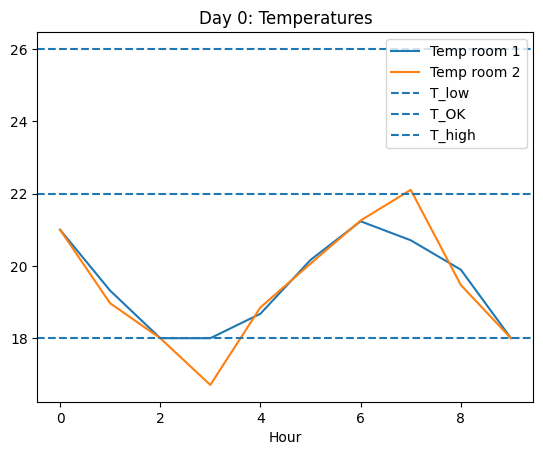

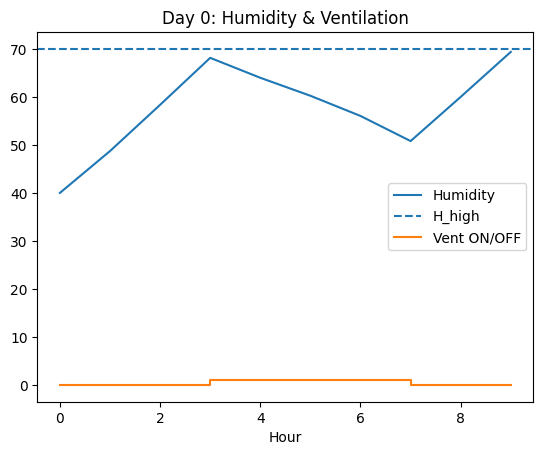

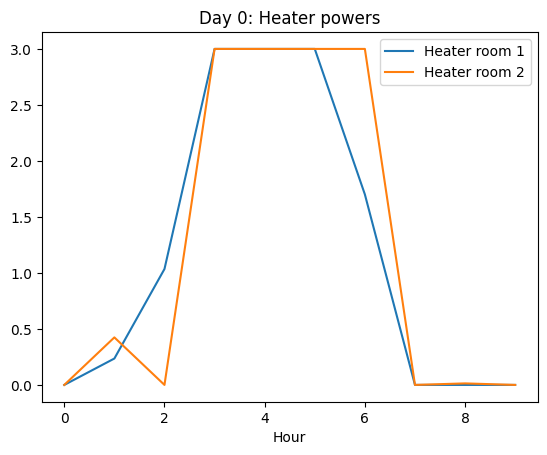

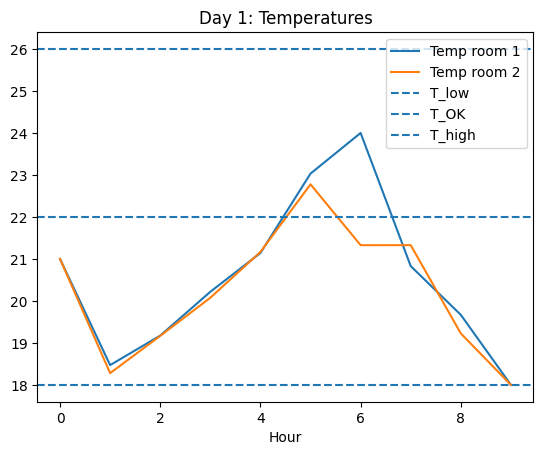

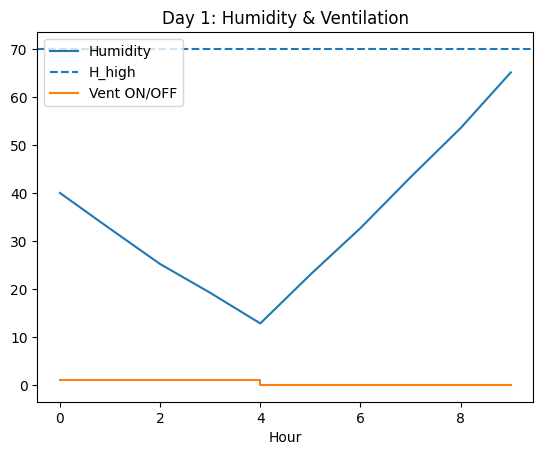

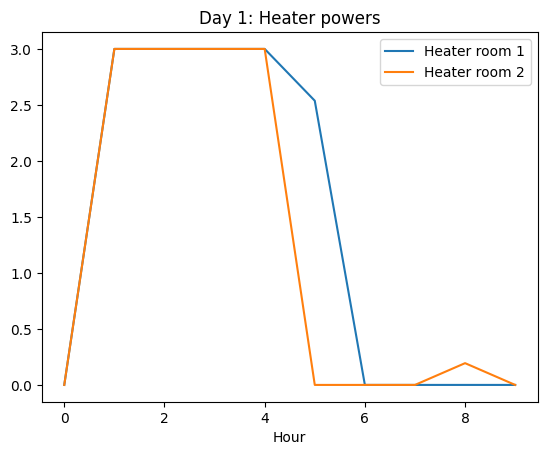

In [33]:
import matplotlib.pyplot as plt

def quick_plot(day_idx, sol, params):
    t = np.arange(len(sol["v"]))

    plt.figure()
    plt.plot(t, sol["T1"], label="Temp room 1")
    plt.plot(t, sol["T2"], label="Temp room 2")
    plt.axhline(params["T_low"], linestyle="--", label="T_low")
    plt.axhline(params["T_ok"], linestyle="--", label="T_OK")
    plt.axhline(params["T_high"], linestyle="--", label="T_high")
    plt.title(f"Day {day_idx}: Temperatures")
    plt.xlabel("Hour")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(t, sol["H"], label="Humidity")
    plt.axhline(params["H_high"], linestyle="--", label="H_high")
    plt.step(t, sol["v"], where="post", label="Vent ON/OFF")
    plt.title(f"Day {day_idx}: Humidity & Ventilation")
    plt.xlabel("Hour")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(t, sol["p1"], label="Heater room 1")
    plt.plot(t, sol["p2"], label="Heater room 2")
    plt.title(f"Day {day_idx}: Heater powers")
    plt.xlabel("Hour")
    plt.legend()
    plt.show()

for d in example_days:
    quick_plot(d, solutions[d], params)
